In [1]:
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

#clustering packages
from sklearn.cluster import KMeans, DBSCAN, AgglomerativeClustering
from scipy.spatial import distance
from scipy.cluster.hierarchy import linkage, fcluster, dendrogram
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

from sklearn.manifold import TSNE, MDS
from sklearn.metrics import silhouette_score

# import other functions
from imputer import *
from feature_eng import *
from drop import *
from PCA_data import *


## Summary

- This notebook prepares the data to be used in `training_mixed_effects_R.ipynb` notebook for modeling mixed effects
- This has 2 parts:
    - To create the data with given categorical columns - `state`, `income_class`, `density_class`, `climate`
    - To create data with Kmeans labels - `2 classes`, `4 classes`
- Slight change in the pre-processing is needed to preprocess the data for Kmeans clustering
- The kmeans models are run for various values of `n_clusters` and silhouette plots show k = 2 or 4 to be the optimal grouping. This is why only these two are used to prepare the data.


In [2]:
df = pd.read_csv("../data/train_data.zip")
df.head()

,external_id,month,year,monthly_number_of_sessions,monthly_unique_sessions,monthly_repeated_sessions,monthly_avg_length_of_session,monthly_avg_light_activity,monthly_avg_moderate_activity,monthly_avg_vigorous_activity,...,avg_wind_9_10,avg_wind_10_11,avg_wind_11_12,avg_wind_12_above,perfect_days,unacast_session_count,hpi,state_and_local_amount_per_capita,state_amount_per_capita,local_amount_per_capita
0,MR00110735,9,2018,0,0,0,0.000000e+00,0.000000,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,72.0,2163.09,0.164303,0.012953,0.151351
1,MR00098439,4,2018,17,2,15,1.133941e+06,330588.235294,373470.588235,0.0,...,0.0,0.0,0.0,0.0,0.0,454.0,823.64,0.132207,0.018519,0.113688
2,3fc0ac8f-15dc-4509-9343-e68c9e0d7ba0,3,2019,0,0,0,0.000000e+00,0.000000,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,388.0,372.76,0.164303,0.012953,0.151351
3,MR00117656,6,2019,0,0,0,0.000000e+00,0.000000,0.000000,0.0,...,0.0,0.0,0.0,0.0,2.0,12.0,491.01,0.164303,0.012953,0.151351
4,MR00103365,6,2019,81,11,70,4.475556e+05,71839.506173,14901.234568,0.0,...,0.0,0.0,0.0,0.0,1.0,1597.0,561.47,0.164303,0.012953,0.151351


In [8]:
## Use this only when using the categorical columns from the data - state, income_class, density_class, climate
def drop_columns_wo_state(input_data):
    """
    Drops some columns that we think are irrelevant from the original dataframe.
    
    Parameters
    ---------------
    
    input_data : pandas.core.frame.DataFrame
    
    Returns
    ---------------
    pandas.core.frame.DataFrame
        
    """
    data = input_data.copy()
    data = data.drop(columns = ['external_id', 'monthly_count_of_holidays', 'B13016e2', 'B19113e1', 'name',
                                'city', 'country', 'county', 'MonthYear', 'date', 
                                'streets_per_node_counts_0', 'streets_per_node_counts_0_osid', 
                                'streets_per_node_counts_0_osdw', 'self_loop_proportion', 'self_loop_proportion_osid', 
                                'self_loop_proportion_osdw', 'circuity_avg', 'circuity_avg_osid', 'circuity_avg_osdw', 
                                'clean_intersection_density_km', 'node_density_km', 'clean_intersection_count_osid', 
                                'node_density_km_osdw', 'intersection_density_km_osdw', 'street_density_km_osid', 
                                'edge_density_km_osid', 'intersection_density_km_osid', 'node_density_km_osid', 
                                'edge_density_km_osdw', 'street_density_km_osdw', 'clean_intersection_count', 
                                'clean_intersection_count_osdw', 'clean_intersection_density_km_osdw', 'street_density_km', 
                                'edge_density_km', 'intersection_density_km', 'clean_intersection_density_km_osid', 
                                'streets_per_node_counts_8', 'streets_per_node_proportion_8', 'streets_per_node_proportion_7_osid', 
                                'streets_per_node_counts_7_osid', 'streets_per_node_proportion_8_osdw', 
                                'streets_per_node_counts_8_osdw', 'streets_per_node_proportion_7', 'streets_per_node_counts_7', 
                                'streets_per_node_counts_7_osdw', 'streets_per_node_proportion_7_osdw', 
                                'streets_per_node_proportion_6_osid', 'streets_per_node_counts_6_osid', 
                                'streets_per_node_proportion_6', 'streets_per_node_counts_6', 'streets_per_node_counts_6_osdw', 
                                'streets_per_node_proportion_6_osdw', 'transit_score', 'closest_place_category', 
                                'closest_place_distance'])
    
    # Gather all `temp_min_*` columns
    temp_list = [i for i in data.columns if re.match('temp_min_*', i)]
    
    # Gather all `streets_per_node_proportion_*` columns
    street_list = [i for i in data.columns if re.match('streets_per_node_proportion_*', i)]

    # Gather all news events columns
    news_state_list = data.loc[:, 'total_events_across_state':'material_conflict_events_across_state'].columns.to_list()
    news_radius_list = data.loc[:, 'total_events_500_meters':'material_conflict_events_2000_meters'].columns.to_list()
    
    # Gather unneeded census columns
    sex_age_list = data.loc[:, 'B01001e27':'B01001e6'].columns.to_list()
    
    # Gather all Biba survey columns
    monthly_survey_list = data.loc[:, ['monthly_weekday_counts', 'monthly_survey']].columns.to_list()
    historic_survey_list = data.loc[:, 'historic_weekday_0':'historic_variety'].columns.to_list()
    
    cols_to_drop =  temp_list + street_list + news_state_list + news_radius_list + sex_age_list \
                    + monthly_survey_list + historic_survey_list

    data = data.drop(columns = cols_to_drop)
        
    return data


## Data preprocess

In [5]:
# drop rows missing target variable
df = drop_missing_unacast(df)

# create X and y
X = df.drop('unacast_session_count', axis=1)
y = df.loc[:, 'unacast_session_count']
# split the data
X_train, X_valid, y_train, y_valid = train_test_split(X, y, 
                                                    test_size=0.2,
                                                      random_state=2020)
# impute NaN values
result = impute_data(X_train, X_valid)
X_train = result[0]
X_valid = result[1] 
# perform feature eng
X_train = comb_cols(X_train)
X_valid = comb_cols(X_valid)
# perform dropping
# uncomment below 2 lines when using KMeans
# X_train = drop_columns(X_train)
# X_valid = drop_columns(X_valid)

X_train = drop_columns_wo_state(X_train)
X_valid = drop_columns_wo_state(X_valid)

# perform OHE (climate, density_class, income_class)
X_train_valid = clean_categorical(X_train, X_valid)
X_train = X_train_valid[0]
X_valid = X_train_valid[1]

## Prepare the grouping data with categorical columns

In [9]:
train_processed = X_train
train_processed['unacast_session_count'] = y_train

valid_processed = X_valid
valid_processed['unacast_session_count'] = y_valid

compression_opts = dict(method='zip',archive_name='out.csv')  

train_processed.to_csv("../data/train_processed_lmer.zip", index = False, compression=compression_opts)
valid_processed.to_csv("../data/valid_processed_lmer.zip", index = False, compression=compression_opts)


## Prepare the grouping data with Kmeans caterogies columns

### Segregating Biba and Census Cols

In [4]:
biba_X_train = pd.concat([X_train.loc[:, 'monthly_number_of_sessions':'distance_to_nearest_bus_stop'],
                            X_train.loc[:, 'monthly_slide_count_comb' : 'historic_ws_moderate_br']], axis = 1)

biba_X_valid = pd.concat([X_valid.loc[:, 'monthly_number_of_sessions':'distance_to_nearest_bus_stop'],
                            X_valid.loc[:, 'monthly_slide_count_comb' : 'historic_ws_moderate_br']], axis = 1)

census_X_train = X_train.loc[:,'B20004e10' : 'avg_age_of_mother']

census_X_valid = X_valid.loc[:,'B20004e10' : 'avg_age_of_mother']


In [5]:
#Scaling the data
scaler = StandardScaler()

biba_X_train_sc = scaler.fit_transform(biba_X_train)
biba_X_valid_sc = scaler.transform(biba_X_valid)

census_X_train_sc = scaler.fit_transform(census_X_train)
census_X_valid_sc = scaler.transform(census_X_valid)


### Starting clustering in Biba data - time taking

In [6]:
# kmeans = []
# for i in range(2,10):
#     kmeans.append(KMeans(n_clusters=i, random_state=2020).fit(biba_X_train_sc))


In [7]:
# s = [silhouette_score(biba_X_train_sc,kmeans[k].labels_) for k in range(0,8)]
# print("score computed")

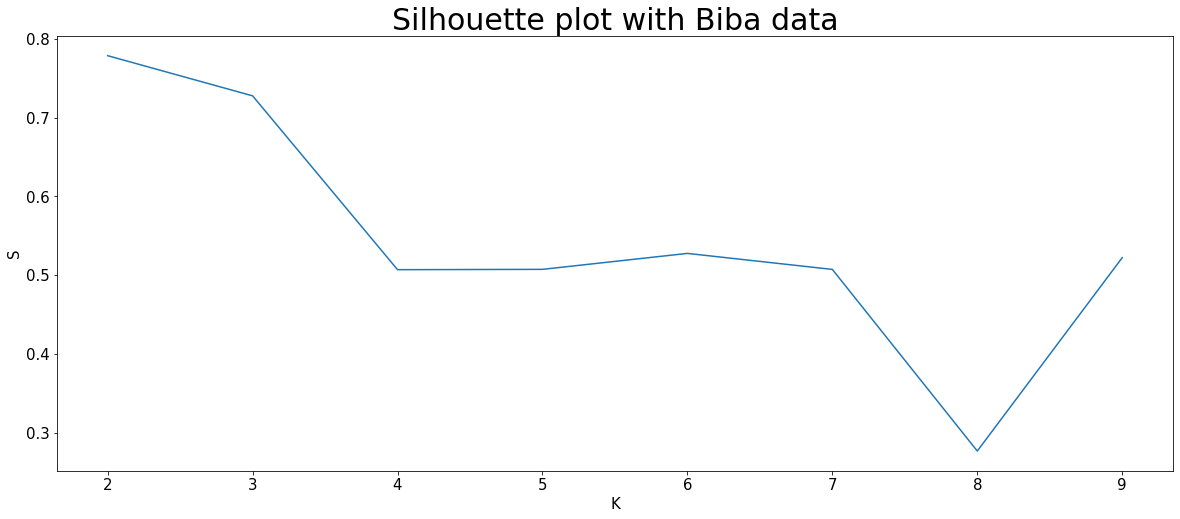

In [83]:
# plt.figure(figsize=(20,8))
# plt.plot(range(2,10), s);
# ax = plt.gca()
# ax.tick_params('both', labelsize=30/2)
# ax.set_xlabel('K', fontsize=15)
# ax.set_ylabel("S", fontsize=15)
# ax.set_title("Silhouette plot with Biba data", fontsize=30)
# plt.show()

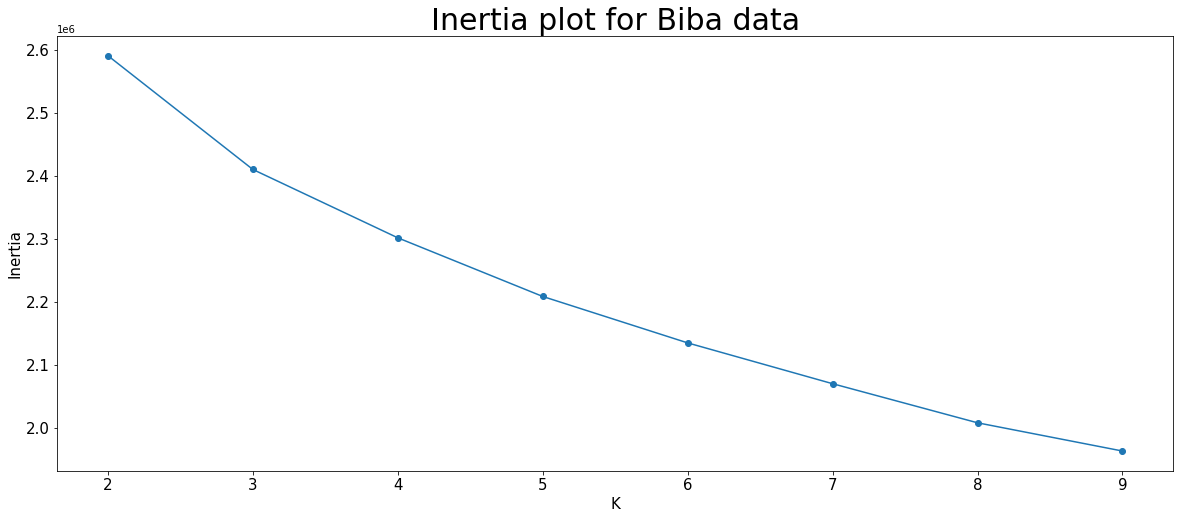

In [84]:
# plt.figure(figsize=(20,8))
# plt.plot(range(2,10),[k.inertia_ for k in kmeans], '-o')
# ax = plt.gca()
# ax.tick_params('both', labelsize=30/2)
# ax.set_xlabel('K', fontsize=15)
# ax.set_ylabel("Inertia", fontsize=15)
# ax.set_title("Inertia plot for Biba data", fontsize=30)
# plt.show()

In [8]:
# kmeans_2_labels_df = pd.DataFrame()
# kmeans_2_labels_df['target'] = y_train.reset_index(drop = True)
# kmeans_2_labels_df['group'] = kmeans[1].labels_
# kmeans_2_labels_df.shape

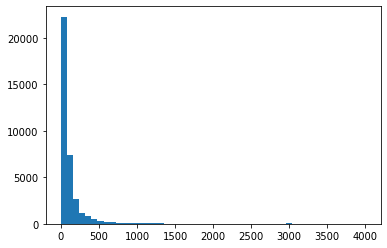

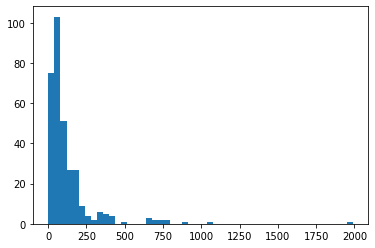

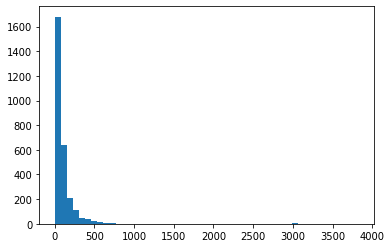

In [87]:
# plt.hist(kmeans_2_labels_df.loc[kmeans_2_labels_df['group'] == 0, 'target'], bins = 50)
# plt.show()

# plt.hist(kmeans_2_labels_df.loc[kmeans_2_labels_df['group'] == 1, 'target'], bins = 50)
# plt.show()

# plt.hist(kmeans_2_labels_df.loc[kmeans_2_labels_df['group'] == 2, 'target'], bins = 50)
# plt.show()


In [9]:
# kmeans_2_labels_df_valid = pd.DataFrame()
# kmeans_2_labels_df_valid['target'] = y_valid.reset_index(drop = True)
# kmeans_2_labels_df_valid['group'] = kmeans[1].predict(biba_X_valid_sc)

# kmeans_2_labels_df_valid.shape

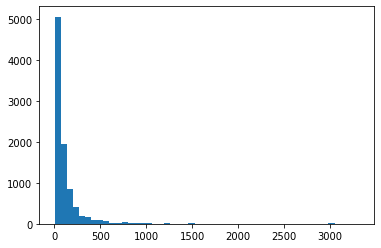

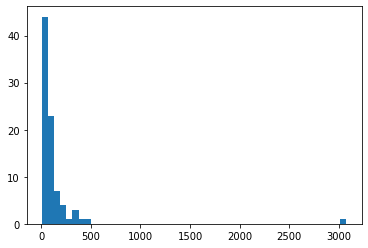

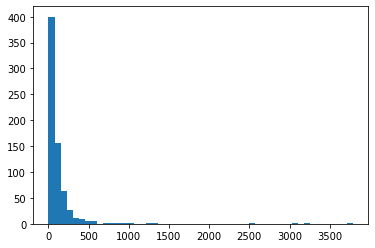

In [94]:
# plt.hist(kmeans_2_labels_df_valid.loc[kmeans_2_labels_df_valid['group'] == 0, 'target'], bins = 50)
# plt.show()

# plt.hist(kmeans_2_labels_df_valid.loc[kmeans_2_labels_df_valid['group'] == 1, 'target'], bins = 50)
# plt.show()

# plt.hist(kmeans_2_labels_df_valid.loc[kmeans_2_labels_df_valid['group'] == 2, 'target'], bins = 50)
# plt.show()


### Starting clustering in Census data - time taking

In [11]:
# kmeans = []
# for i in range(2,10):
#     kmeans.append(KMeans(n_clusters=i, random_state=2020).fit(census_X_train_sc))


In [10]:
# s = [silhouette_score(census_X_train_sc,kmeans[k].labels_) for k in range(0,8)]
# print("score computed")

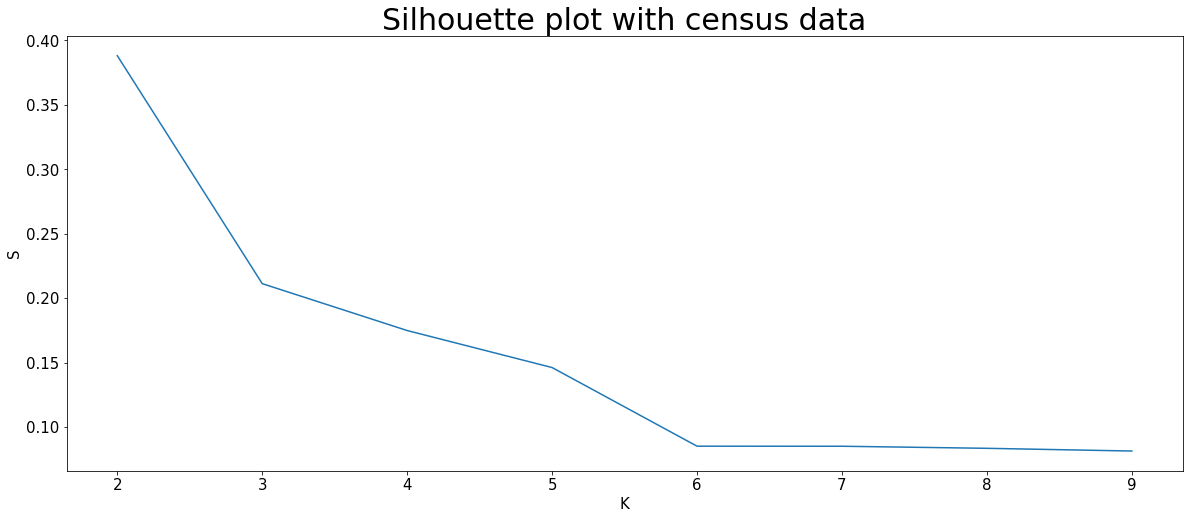

In [98]:
# plt.figure(figsize=(20,8))
# plt.plot(range(2,10), s);
# ax = plt.gca()
# ax.tick_params('both', labelsize=30/2)
# ax.set_xlabel('K', fontsize=15)
# ax.set_ylabel("S", fontsize=15)
# ax.set_title("Silhouette plot with census data", fontsize=30)
# plt.show()

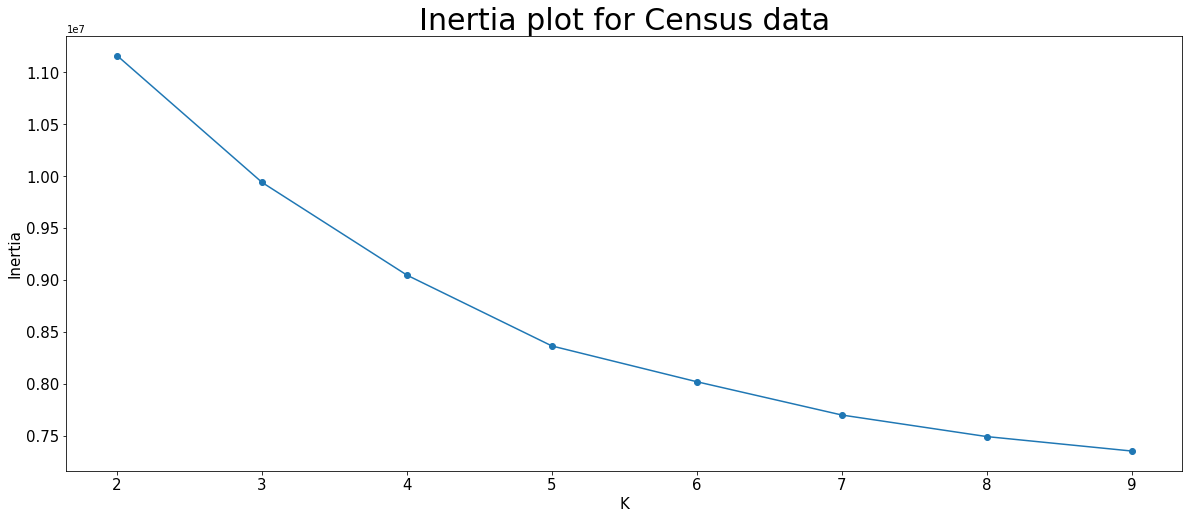

In [99]:
# plt.figure(figsize=(20,8))
# plt.plot(range(2,10),[k.inertia_ for k in kmeans], '-o')
# ax = plt.gca()
# ax.tick_params('both', labelsize=30/2)
# ax.set_xlabel('K', fontsize=15)
# ax.set_ylabel("Inertia", fontsize=15)
# ax.set_title("Inertia plot for Census data", fontsize=30)
# plt.show()

In [12]:
# kmeans_2_labels_df = pd.DataFrame()
# kmeans_2_labels_df['target'] = y_train.reset_index(drop = True)
# kmeans_2_labels_df['group'] = kmeans[0].labels_
# kmeans_2_labels_df.shape

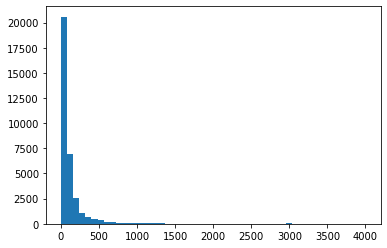

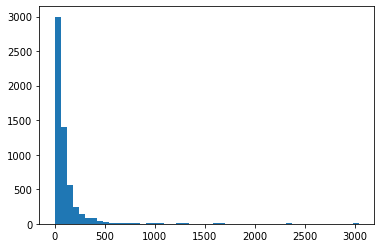

In [103]:
# plt.hist(kmeans_2_labels_df.loc[kmeans_2_labels_df['group'] == 0, 'target'], bins = 50)
# plt.show()
# plt.hist(kmeans_2_labels_df.loc[kmeans_2_labels_df['group'] == 1, 'target'], bins = 50)
# plt.show()


In [13]:
# kmeans_2_labels_df_valid = pd.DataFrame()
# kmeans_2_labels_df_valid['target'] = y_valid.reset_index(drop = True)
# kmeans_2_labels_df_valid['group'] = kmeans[0].predict(census_X_valid_sc)
# kmeans_2_labels_df_valid.shape

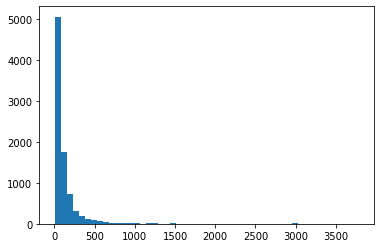

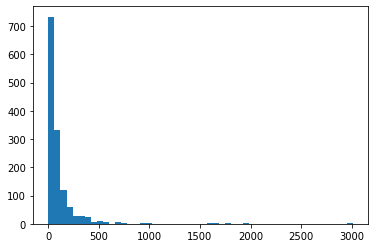

In [104]:
# plt.hist(kmeans_2_labels_df_valid.loc[kmeans_2_labels_df_valid['group'] == 0, 'target'], bins = 50)
# plt.show()
# plt.hist(kmeans_2_labels_df_valid.loc[kmeans_2_labels_df_valid['group'] == 1, 'target'], bins = 50)
# plt.show()

## Clustering on all features - time taking

In [7]:
scaler = StandardScaler()

X_train_sc = scaler.fit_transform(X_train)
X_valid_sc = scaler.transform(X_valid)

In [15]:
# kmeans = []
# for i in range(2,5):
#     kmeans.append(KMeans(n_clusters=i, random_state=2020).fit(X_train_sc))

In [16]:
# s = [silhouette_score(X_train_sc,kmeans[k].labels_) for k in range(0,3)]
# print("score computed")

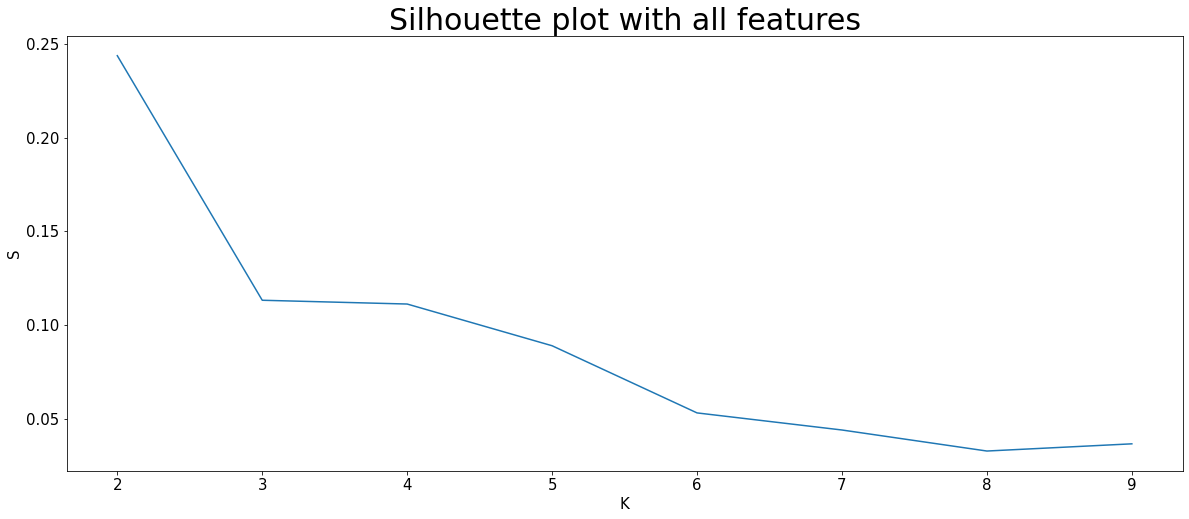

In [7]:
# plt.figure(figsize=(20,8))
# plt.plot(range(2,5), s);
# ax = plt.gca()
# ax.tick_params('both', labelsize=30/2)
# ax.set_xlabel('K', fontsize=15)
# ax.set_ylabel("S", fontsize=15)
# ax.set_title("Silhouette plot with all features", fontsize=30)
# plt.show()

In [17]:
# kmeans_labels_df_train = pd.DataFrame()
# kmeans_labels_df_train['target'] = y_train.reset_index(drop = True)
# kmeans_labels_df_train['group'] = kmeans[0].labels_
# kmeans_labels_df_train.shape

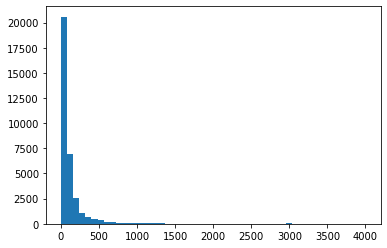

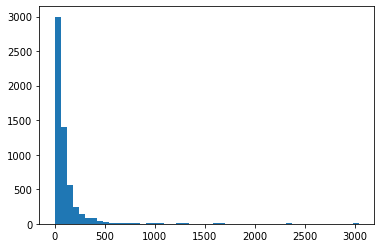

In [112]:
# plt.hist(kmeans_2_labels_df.loc[kmeans_2_labels_df['group'] == 0, 'target'], bins = 50)
# plt.show()
# plt.hist(kmeans_2_labels_df.loc[kmeans_2_labels_df['group'] == 1, 'target'], bins = 50)
# plt.show()


## Using PCA on all features - time taking

In [18]:
X_train_pca = pca_fit_transform(X_train)
X_valid_pca = pca_transform(X_valid)

print(X_train_pca.shape)
print(X_valid_pca.shape)

(39592, 352)
(9898, 352)


In [19]:
# kmeans = []
# for i in range(2,10):
#     kmeans.append(KMeans(n_clusters=i, random_state=2020).fit(X_train_pca))

In [20]:
# s = [silhouette_score(X_train_pca,kmeans[k].labels_) for k in range(0,8)]
# print("score computed")

In [21]:
# plt.figure(figsize=(20,8))
# plt.plot(range(2,10), s);
# ax = plt.gca()
# ax.tick_params('both', labelsize=30/2)
# ax.set_xlabel('K', fontsize=15)
# ax.set_ylabel("S", fontsize=15)
# ax.set_title("Silhouette plot with PCA features", fontsize=30)
# plt.show()

In [22]:
# kmeans_labels_df_train = pd.DataFrame()
# kmeans_labels_df_train['target'] = y_train.reset_index(drop = True)
# kmeans_labels_df_train['group'] = kmeans[2].labels_
# kmeans_labels_df_train.shape

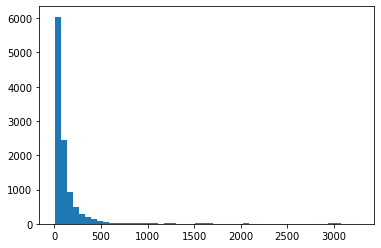

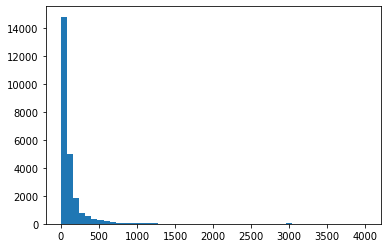

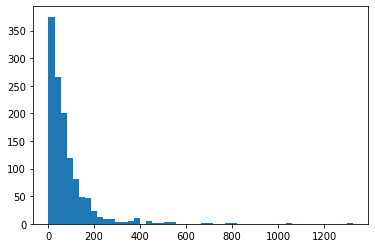

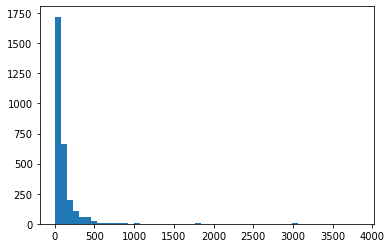

In [24]:
# plt.hist(kmeans_labels_df_train.loc[kmeans_labels_df_train['group'] == 0, 'target'], bins = 50)
# plt.show()
# plt.hist(kmeans_labels_df_train.loc[kmeans_labels_df_train['group'] == 1, 'target'], bins = 50)
# plt.show()
# plt.hist(kmeans_labels_df_train.loc[kmeans_labels_df_train['group'] == 2, 'target'], bins = 50)
# plt.show()
# plt.hist(kmeans_labels_df_train.loc[kmeans_labels_df_train['group'] == 3, 'target'], bins = 50)
# plt.show()


### Creating data with kmeans labels 

### Possible if all the required codes are run before

In [23]:
# X_train['Kmeans_2_label'] = kmeans[0].labels_
# X_train['Kmeans_4_label'] = kmeans[2].labels_

# X_valid['Kmeans_2_label'] = kmeans[0].predict(X_valid_sc)
# X_valid['Kmeans_4_label'] = kmeans[2].predict(X_valid_sc)


In [24]:
# train_processed = X_train
# train_processed['unacast_session_count'] = y_train

# valid_processed = X_valid
# valid_processed['unacast_session_count'] = y_valid


In [25]:
# compression_opts = dict(method='zip',archive_name='out.csv')  
# train_processed.to_csv("../data/train_processed.zip", index = False, compression=compression_opts)
# valid_processed.to_csv("../data/valid_processed.zip", index = False, compression=compression_opts)
